In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from IPython.display import Image
import itertools
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
plt.show()

In [52]:
#Explicación dataset

In [53]:
data = pd.read_csv("Data/data.csv")

In [54]:
data.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [55]:
#borrando primera columna, correspondiente a la identificación del paciente
#Visualizacion de las primeras 5 filas del dataset

In [56]:
del data["Unnamed: 0"]
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [57]:
# Se hace revisión de valores null
# No hay necesidad de realizar one hot encoding porque todos los datos son numéricos

In [58]:
np.sum(np.sum(data.isna()))

0

In [59]:
#Método utilizado para mostrar la matriz de confusión
#Matriz de confusión: usage to evaluate the quality of the output of a classifier on the iris data set. 
#The diagonal elements represent the number of points for which the predicted label is equal to the true label, 
#while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the 
#confusion matrix the better, indicating many correct predictions.

In [60]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [61]:
#Método utilizado para mostrar las curvas de aprendizaje

In [62]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim != None:
        plt.ylim(*ylim)
    plt.xlabel("Training samples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Train score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score")

    plt.legend(loc="best")
    return plt

In [63]:
#Variables para el desarrollo de la predicción

In [64]:
X = data
y = data["y"]

In [65]:
#Regresión logística
#En la implementación del algoritmo, se utiliza lbfgs como solver porque soporta multiclase, y multinomial por la misma razón.
#Como se puede observar el accuracy de LR es muy baja, debido a que la complejidad del modelo es muy simple 
#para este tipo de clasificación.
#En la curva de aprendizaje puede observarse que al principio hay un overfitting, pero comienza a desaparecer a medida
#que se añaden datos de training.

In [66]:
def logisticRegression(X, y):
    Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=0.3)
    clf = LogisticRegression(solver='lbfgs', multi_class='multinomial')
    clf.fit(Xtr, ytr)
    predicts = clf.predict(Xts)
    acc = clf.score(Xts, yts)
    print "Logistic regression reports:\n", classification_report(yts, predicts)
    print "Logistic regression accuracy:", acc
    return confusion_matrix(yts, predicts), clf

In [67]:
#Matriz de confusión y reportes

Logistic regression reports:
             precision    recall  f1-score   support

          1       0.69      0.31      0.43       677
          2       0.17      0.03      0.06       678
          3       0.08      0.02      0.03       726
          4       0.20      0.27      0.23       641
          5       0.28      0.76      0.41       728

avg / total       0.28      0.28      0.23      3450

Logistic regression accuracy: 0.28231884057971013


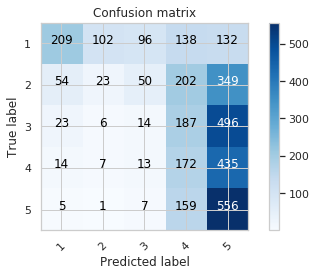

In [68]:
conf_matrix, clf = logisticRegression(X, y)
plt.figure()
plot_confusion_matrix(conf_matrix, classes=['1', '2', '3', '4', '5'], title='Confusion matrix')
plt.show()

In [69]:
#Curva de aprendizaje

<module 'matplotlib.pyplot' from '/opt/miniconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

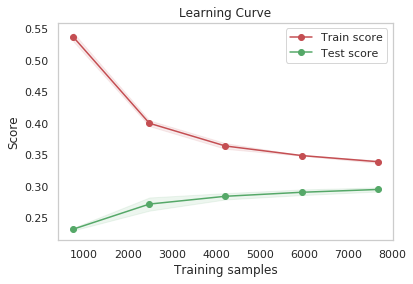

In [70]:
plot_learning_curve(clf, "Learning Curve", X, y)

In [71]:
#SVM
#The multiclass support is handled according to a one-vs-one scheme.
#Debido a que la complejidad de SVM en training es más que cuadrática se hace complicado aplicarlo para este dataset debido
#al tamaño de este. Por esto mismo es dificil realizar validación de parámetros, debido al tiempo de ejecución.
#Se probó con un polinomio de grado 3 y 5, pero el que mejor resultados arrojo fue de grado 2, se intentó variar
#parametros pero toma mucho tiempo para la ejecución.
#Debido a lo anterior se decidió probar con 5000 datos del data set para ver cómo se comportaba el algoritmo (ver imágenes)
#En la curva de aprendizaje se puede apreciar un overfitting, y a pesar de que disminuye a medida que se agregan datos de 
#train, aún así es muy grande.
#El tipo de kernel elegido fue el polinomial por el tipo de tarea de clasificación, de grado 2 porque fue le que mejor
#accuracy arrojó y el valor de gamma se decidió dejarlo auto lo que significa que es calculado como: 1 / n_features

In [39]:
def svm(X, y):
    print "calculating..."
    Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=0.2)
    clf = SVC(kernel="poly", degree=2, gamma = "auto")
    clf.fit(Xtr, ytr)
    predicts = clf.predict(Xts)
    acc = clf.score(Xts, yts)
    print "SVM reports:\n", classification_report(yts, predicts)
    print "SVM accuracy:", acc
    return confusion_matrix(yts, predicts), clf

In [40]:
#Matriz de confusión y reportes

calculating...
SVM reports:
             precision    recall  f1-score   support

          1       0.93      0.93      0.93       463
          2       0.50      0.61      0.55       444
          3       0.53      0.52      0.53       447
          4       0.73      0.73      0.73       479
          5       0.65      0.54      0.59       467

avg / total       0.67      0.67      0.67      2300

SVM accuracy: 0.6669565217391304


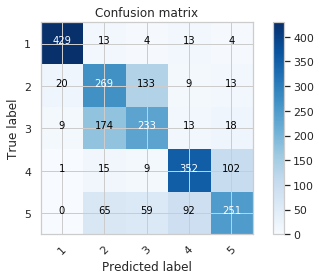

In [41]:
conf_matrix, clf = svm(X, y)
plt.figure()
plot_confusion_matrix(conf_matrix, classes=['1', '2', '3', '4', '5'], title='Confusion matrix')
plt.show()

In [42]:
#Curva de aprendizaje

<module 'matplotlib.pyplot' from '/opt/miniconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

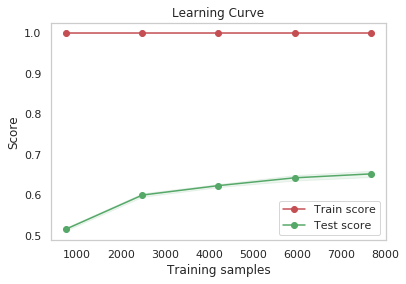

In [43]:
plot_learning_curve(clf, "Learning Curve", X, y)

In [72]:
#Las siguientes imágenes muestran los resultados de SVM con 5000 datos y las siguientes características: 

In [73]:
#-Grado del polinomio 2:

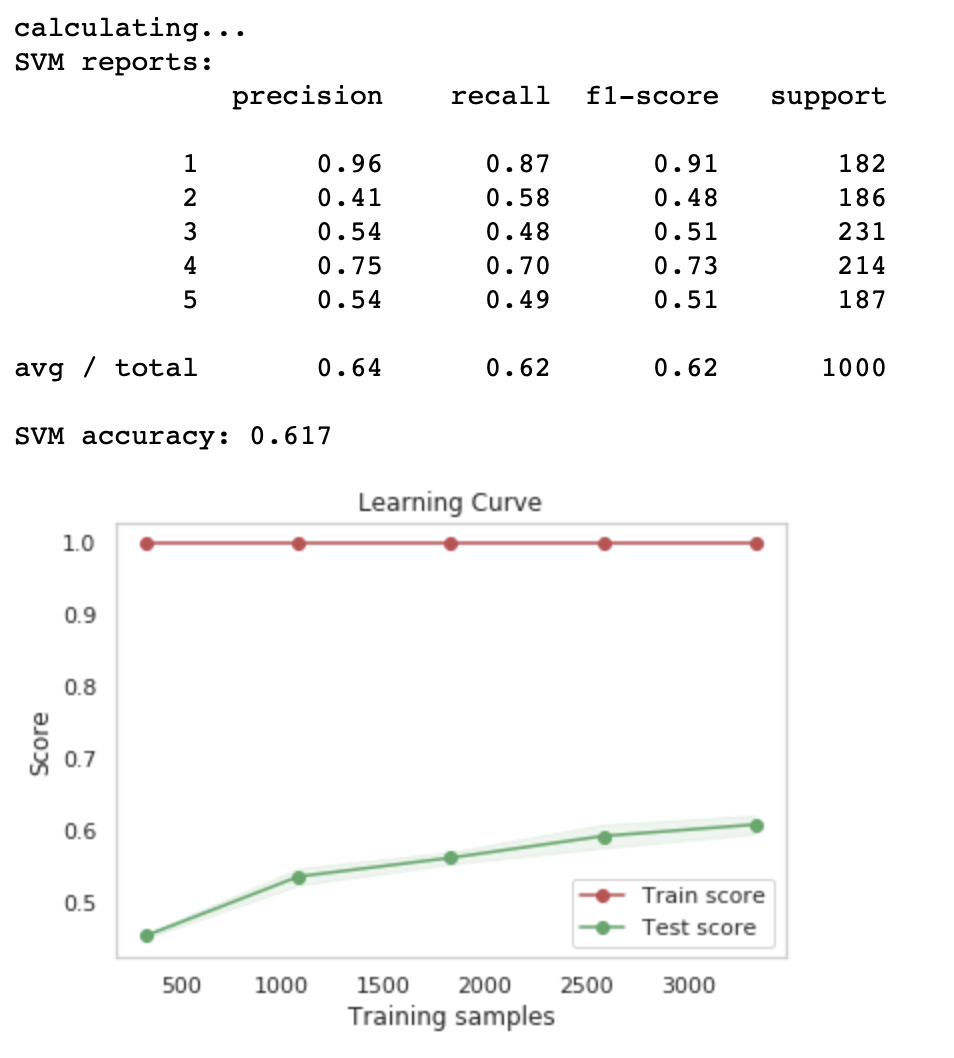

In [78]:
Image(filename='grado2_5milDatos.png',width = 500, height = 500)

In [79]:
#-Grado del polinomio 3:

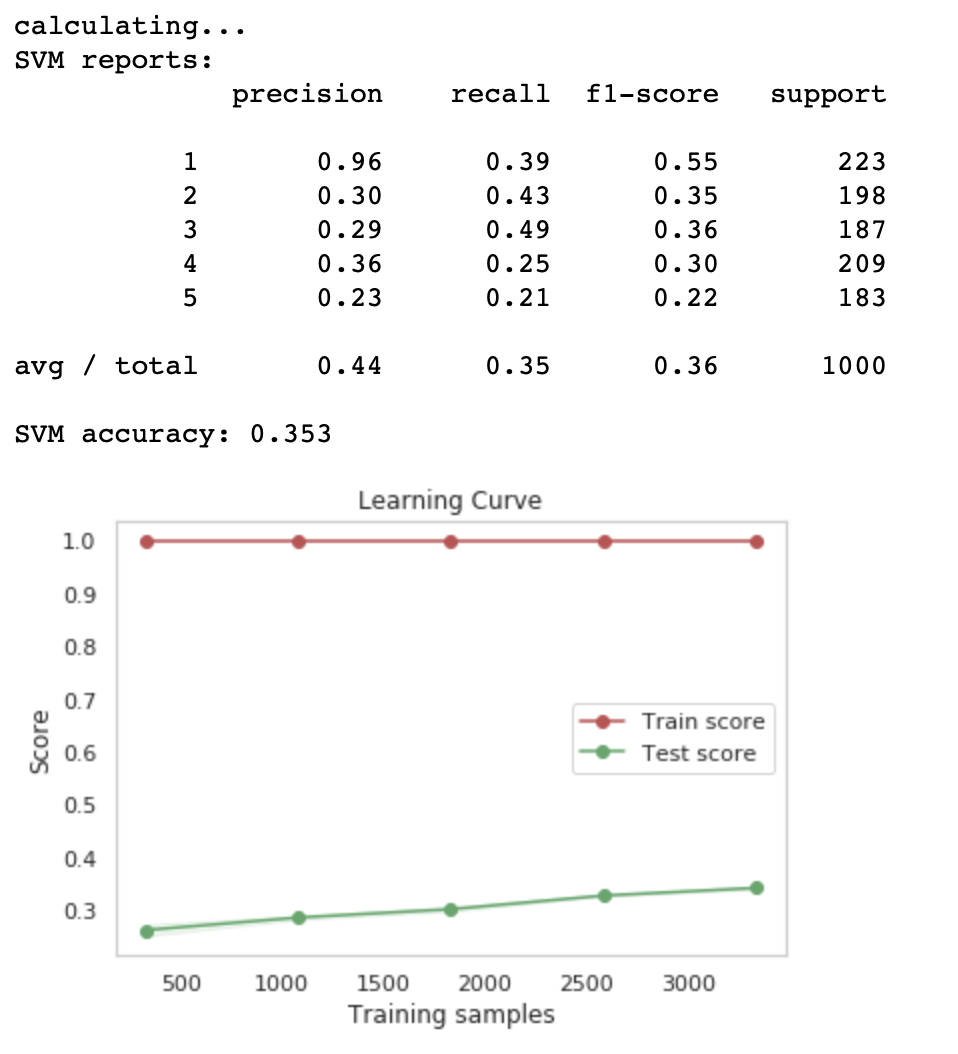

In [80]:
Image(filename='grado3_5milDatos.png',width = 500, height = 500)

In [83]:
#-Grado del polinomio 5:

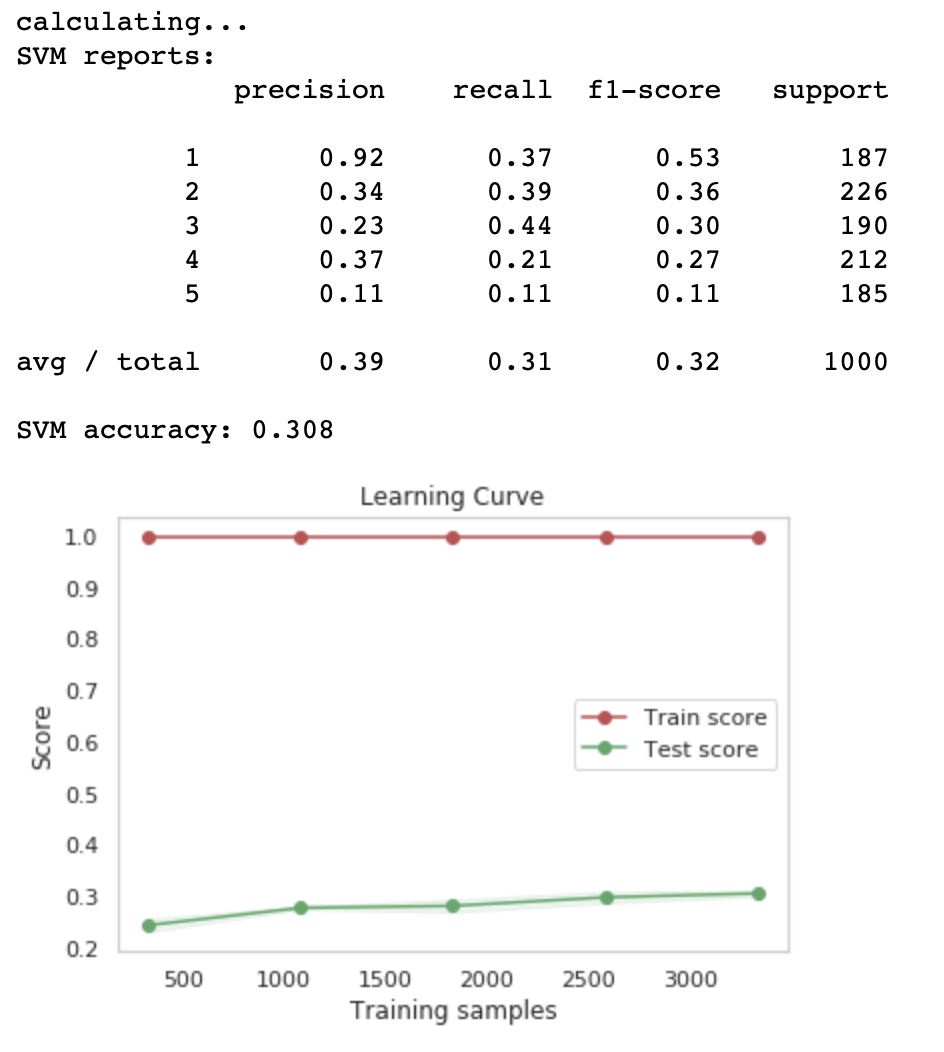

In [84]:
Image(filename='grado5_5milDatos.png',width = 500, height = 500)

In [85]:
#Random Forest
#A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 
#Random Forest fue un algoritmo que tuvo un muy buen desempeño y precisión clasificando.
#Se decidió implementarlo con una profundidad de 17 porque mostraba muy buen desempeño tanto en accuracy como en la curva
#de aprendizaje. Además, que se hizo el análisis de validación para varias profundidades y se calculó el accuracy para cada uno(ver gráfico)
#En la curva de aprendizaje puede apreciarse un overfitting pero este disminuye a medida que se aumentan los datos de train.

In [86]:
#Método usado para evaluar Random Forest con parámetros diferentes

In [87]:
def changeValuesRandomForest(X, y):
    print "Calculating for multiple depths..."
    plt.figure()
    max_depths = range(1, 25)
    predicts = np.array([cross_val_score(RandomForestClassifier(max_depth=i), X, y, cv=5) for i in max_depths])
    plt.plot(max_depths, predicts[:,0], "o-", color="green", label="Test")
    plt.grid()
    plt.xlabel("Random Forest max depth")
    plt.ylabel("Accuracy")

In [88]:
def randomForest(X, y):
    print "calculating..."
    Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=0.3)
    clf = RandomForestClassifier(max_depth=17)
    clf.fit(Xtr, ytr)
    predicts = clf.predict(Xts)
    acc = clf.score(Xts, yts)
    print "Random Forest reports:\n", classification_report(yts, predicts)
    print "Random Forest accuracy:", acc
    return confusion_matrix(yts, predicts), clf

In [89]:
#Matriz de confusión y reportes

calculating...
Random Forest reports:
             precision    recall  f1-score   support

          1       0.97      0.93      0.95       718
          2       0.92      0.95      0.93       693
          3       0.92      0.92      0.92       693
          4       0.94      0.95      0.95       676
          5       1.00      1.00      1.00       670

avg / total       0.95      0.95      0.95      3450

Random Forest accuracy: 0.9507246376811594


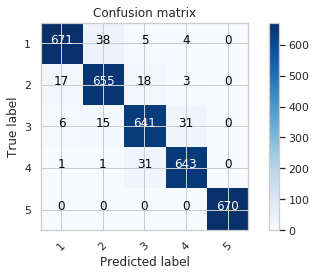

In [93]:
conf_matrix, clf = randomForest(X, y)
plt.figure()
plot_confusion_matrix(conf_matrix, classes=['1', '2', '3', '4', '5'], title='Confusion matrix')
plt.show()

In [94]:
#Curva de aprendizaje

<module 'matplotlib.pyplot' from '/opt/miniconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

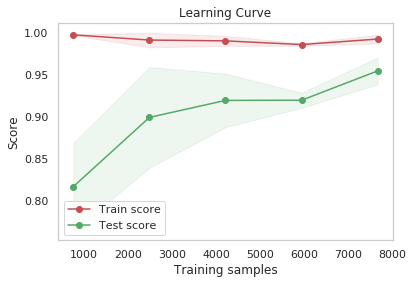

In [95]:
plot_learning_curve(clf, "Learning Curve", X, y)

In [96]:
#Resultado del cambio de parámetros

Calculating for multiple depths...


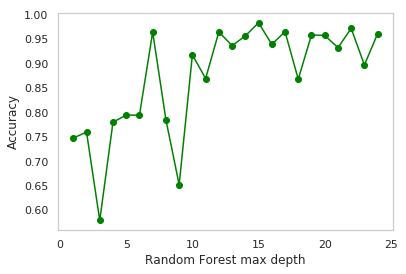

In [97]:
changeValuesRandomForest(X, y)
plt.show()

In [98]:
#Decision Tree
#The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.
#Decision Tree es un algoritmo que tuvo un resultado perfecto en la clasificación.
#Se decidió implementarlo con una profundidad de 4 porque mostraba muy buen desempeño tanto en accuracy como en la curva
#de aprendizaje. Además, que se hizo el análisis de validación para varias profundidades y se calculó el accuracy para cada uno(ver gráfico)
#En la curva de aprendizaje se puede apreciar que no hay overfitting y prácticamente no hay varianza alguna.
#El algoritmo se desempeña muy bien en esta tarea.

In [99]:
#Método usado para evaluar Decision Tree con parámetros diferentes

In [100]:
def changeValuesDecisionTree(X, y):
    print "Calculating for multiple depths..."
    plt.figure()
    max_depths = range(1, 25)
    predicts = np.array([cross_val_score(DecisionTreeClassifier(max_depth=i), X, y, cv=5) for i in max_depths])
    plt.plot(max_depths, predicts[:,0], "o-", color="green", label="Test")
    plt.grid()
    plt.xlabel("Decision tree max depth")
    plt.ylabel("Accuracy")

In [101]:
def decisionTree(X, y):
    print "calculating..."
    Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=0.3)
    clf = DecisionTreeClassifier(max_depth=4);
    clf.fit(Xtr, ytr)
    predicts = clf.predict(Xts)
    acc = clf.score(Xts, yts)
    print "Decision tree reports:\n", classification_report(yts, predicts)
    print "Decision tree accuracy:", acc
    return confusion_matrix(yts, predicts), clf

In [102]:
#Matriz de confusión y reportes

calculating...
Decision tree reports:
             precision    recall  f1-score   support

          1       1.00      1.00      1.00       689
          2       1.00      1.00      1.00       693
          3       1.00      1.00      1.00       680
          4       1.00      1.00      1.00       702
          5       1.00      1.00      1.00       686

avg / total       1.00      1.00      1.00      3450

Decision tree accuracy: 1.0


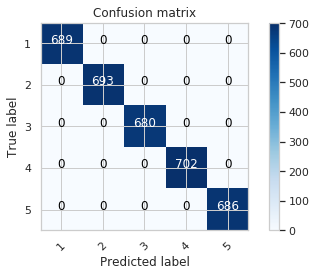

In [103]:
conf_matrix, clf = decisionTree(X, y)
plt.figure()
plot_confusion_matrix(conf_matrix, classes=['1', '2', '3', '4', '5'], title='Confusion matrix')
plt.show()

In [104]:
#Curva de aprendizaje

<module 'matplotlib.pyplot' from '/opt/miniconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

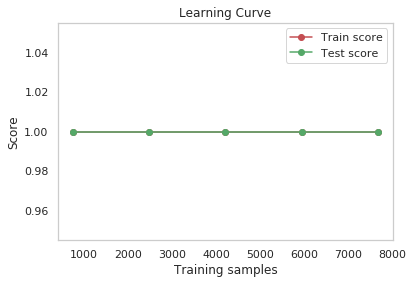

In [105]:
plot_learning_curve(clf, "Learning Curve", X, y)

In [106]:
#Resultado del cambio de parámetros

Calculating for multiple depths...


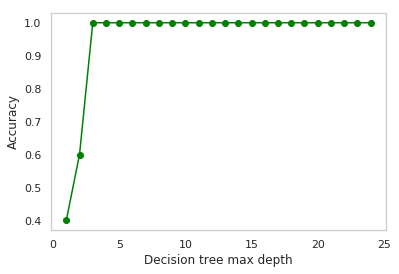

In [107]:
changeValuesDecisionTree(X, y)
plt.show()

In [108]:
#KNN
#Classifier implementing the k-nearest neighbors vote.
#Cabe destacar que se recomiendan vecinos impares para evitar un empate al momento de decidir la clase.
#Este algoritmo no tuvo muy buen desempeño en esta tarea. Además que el tiempo que toma para ejecutar también es considerablemente
#alto.
#Se decide implementarlo con 23 vecinos porque en la validación se encontró que era un número con el cual el overfitting 
#disminuia, sin embargo, se pierde accuracy.
#Si se aumenta el número de vecinos se reduce el overfitting pero se pierde accuracy(ver imagen)
#La curva de aprendizaje muestra un comportamiento creciente respecto al score en train y test a medida que aumentan los
#datos de train. No se aprecia un overfitting significante.

In [109]:
#Método usado para evaluar KNN con parámetros diferentes

In [110]:
def changeValuesKNN(X, y):
    print "This might take several minutes, please be patience."
    print "Calculating for multiple neighbors..."
    plt.figure()
    num_neighbors = range(1, 25, 2)
    predicts = np.array([cross_val_score(KNeighborsClassifier(n_neighbors=i), X, y, cv=5) for i in num_neighbors])
    plt.plot(num_neighbors, predicts[:,0], "o-", color="green", label="Test")
    plt.grid()
    plt.xlabel("KNN neighbors")
    plt.ylabel("Accuracy")

In [111]:
def knn(X, y):
    print "calculating..."
    Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=0.2)
    clf = KNeighborsClassifier(n_neighbors=23);
    clf.fit(Xtr, ytr)
    predicts = clf.predict(Xts)
    acc = clf.score(Xts, yts)
    print "KNN reports:\n", classification_report(yts, predicts)
    print "KNN accuracy:", acc
    return confusion_matrix(yts, predicts), clf

In [112]:
#Matriz de confusión y reportes

calculating...
KNN reports:
             precision    recall  f1-score   support

          1       0.99      0.61      0.76       462
          2       0.32      0.52      0.39       452
          3       0.31      0.69      0.43       465
          4       0.77      0.21      0.33       462
          5       0.16      0.05      0.07       459

avg / total       0.51      0.41      0.40      2300

KNN accuracy: 0.41391304347826086


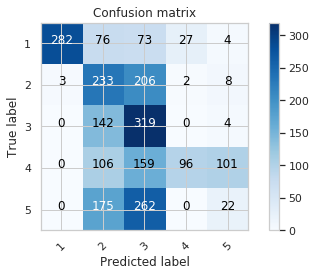

In [113]:
conf_matrix, clf = knn(X, y)
plt.figure()
plot_confusion_matrix(conf_matrix, classes=['1', '2', '3', '4', '5'], title='Confusion matrix')
plt.show()

In [114]:
#Curva de aprendizaje

<module 'matplotlib.pyplot' from '/opt/miniconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

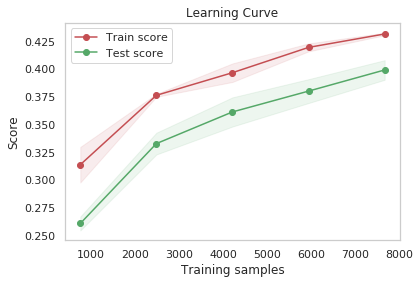

In [115]:
plot_learning_curve(clf, "Learning Curve", X, y)

In [116]:
#Resultado del cambio de parámetros

This might take several minutes, please be patience.
Calculating for multiple neighbors...


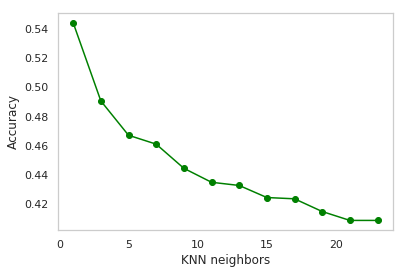

In [117]:
changeValuesKNN(X, y)
plt.show()

In [120]:
#La siguiente imagen muestra los resultados de la ejecución de KNN con n_neighbors = 1

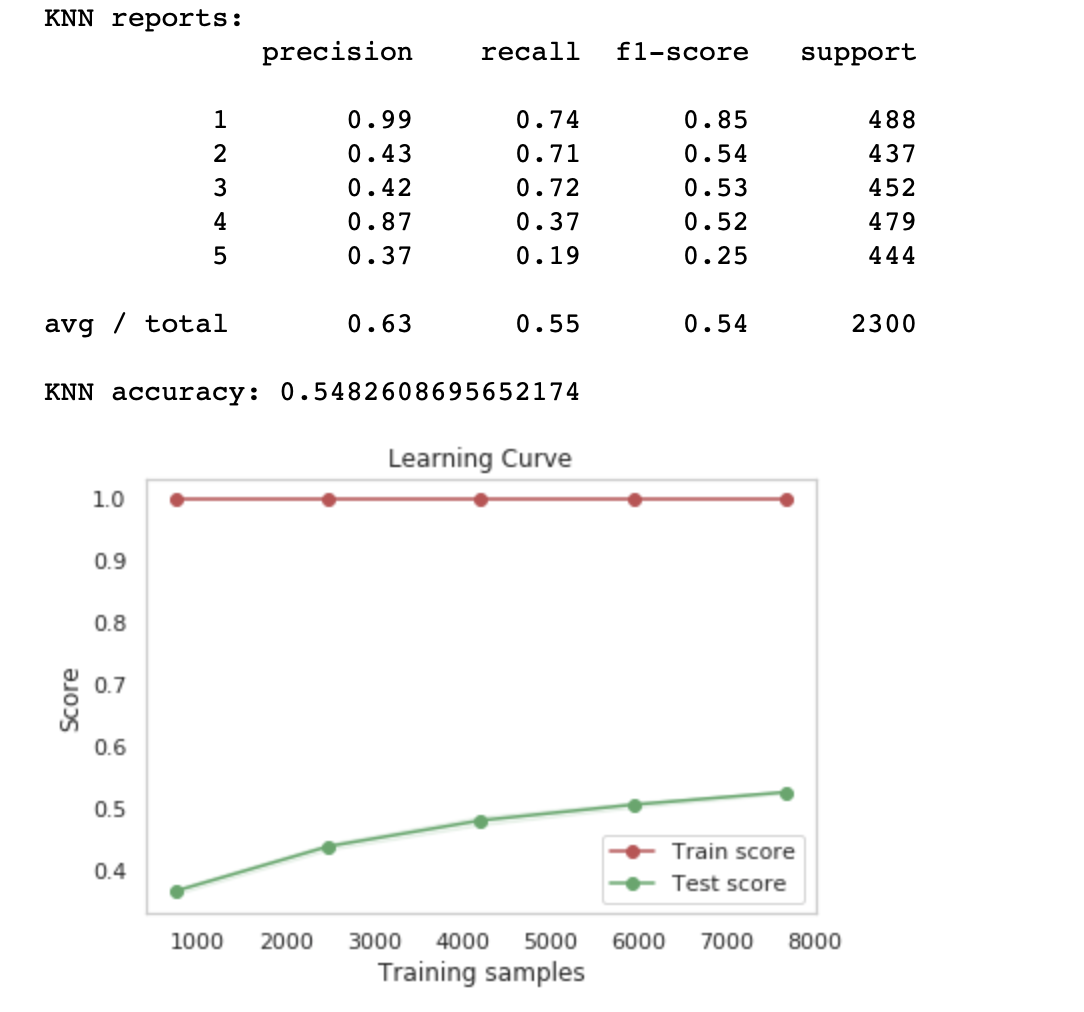

In [121]:
Image(filename='KNN con 1 vecino.png',width = 500, height = 500)